# AprilTag Minimal Working Example with Dedicated Hardware 

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AccelerationConsortium/ac-training-lab/blob/main/src/ac_training_lab/apriltag_hardware_demo/apriltag_hardware_demo.ipynb)


## Introduction 

### What this system does

This system uses a rotating turntable, AprilTag visual markers, and a MyCobot robotic arm to identify, localize, and manipulate vials. The robot can automatically pick up or place vials at specified positions on the turntable.

### Why AprilTags are used

AprilTags provide robust and accurate visual markers that enable the system to detect specific positions on the turntable. Since tags are attached to the turntable (not the vials), they help determine the vial’s location indirectly through a mapping. This allows the system to precisely stop the turntable at the right spot for pick-and-place operations.

### How the workflow proceeds in steps
1. After startup, the turntable rotates slowly.
2. A fixed camera captures frames continuously to detect AprilTags.
3. When the target tag is found, the turntable stops and the corresponding vial is aligned for interaction.
4. The tag’s position is recalculated and converted into robot coordinates using a pre-calibrated transformation matrix.
5. The robot arm grabs or places the vial from the side.

## Configuration

To explore the demo with default files and settings, enable test mode below. If test mode is enabled, you can skip all parameter modifications in this demo.

In [7]:
# @markdown Set `test = True` to use default files and parameters.
test = True  # @param {type:"boolean"}

## Requirements

This notebook requires the following files and libraries. 

In [1]:
# only install if we are running in colab
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    %pip install --upgrade gradio_client

## Live Stream

##### Watch the live demo here: https://www.youtube.com/playlist?list=PL8uZlc2CEpelrYXunUzUOMJC17wEhiP6Q

This live stream shows the dedicated hardware in action, giving you a real-time view of what’s happening in the lab.
You’ll see the AprilTags, turntable, and cobot working together to complete the workflow.
As you run the notebook, each step is mirrored by real-world motion.

> Tips: For a smoother experience, use Picture-in-Picture mode to keep the live stream visible while interacting with the notebook (right-click the video twice in Google Chrome or Microsoft Edge), or consider using split screen to view the notebook and stream side by side.


## Static configuration

Predefined system parameters, determined by the hardware setup and relative positioning.

#### **⚠ Do not modify any of them.**


### Tracking vials in turntable
To track each specific vial and its current position, as well as whether a turntable position is occupied, we maintain two bidirectional mappings in the program:

- Turntable ID ↔ AprilTag ID
- Turntable ID ↔ Vial ID

This allows the program to identify the corresponding AprilTag and vial for each position, so users can assign a specific vial to a specific slot.

> Note:  You can refer to the livestream to visually confirm the mapping. The key in the vial_to_turntable dictionary is the vial ID, and the value is the turntable position ID.


In [ ]:
# Static configuration
# Only positions currently occupied by vials
vial_to_turntable = {
    'vial_1': 3, # vial_1 is currently placed at turntable position 3
    'vial_2': 1,
    'vial_3': 5,
}

# All turntable positions and their associated AprilTags
turntable_to_tag = {
    1: 'tag_01', # turntable position 1 is labeled by tag_01
    2: 'tag_02',
    3: 'tag_03',
    4: 'tag_04',
    5: 'tag_05',
    6: 'tag_06',
    7: 'tag_07',
    8: 'tag_08',
    
}

# Generate reverse mappings
tag_to_turntable = {v: k for k, v in turntable_to_tag.items()}
turntable_to_vial = {v: k for k, v in vial_to_turntable.items()}

### Camera Intrinsics

Camera intrinsics obtained from camera calibration, including camera matrix and distortion coefficients. Used for AprilTag detection and pose estimation.

In [227]:
# @title Load Camera Calibration (DO NOT MODIFY)
import os
import numpy as np

current_dir = os.getcwd()  # already in apriltag_hardware_demo/
camera_params_path = os.path.join(current_dir, "camera_params.npy")

camera_params = np.load(camera_params_path, allow_pickle=True).item()
K = camera_params["camera_matrix"]
dist = camera_params["dist_coeff"]

camera_intrinsics = (K, dist)
print(camera_intrinsics)

(array([[500.60538814,   0.        , 322.65468596],
       [  0.        , 500.61877387, 235.38114207],
       [  0.        ,   0.        ,   1.        ]]), array([[ 0.06654223, -0.07953492,  0.00053151,  0.00130237, -0.04796668]]))



### Hand-Eye Calibration Result

Camera intrinsics obtained from camera calibration, including camera matrix and distortion coefficients. Used for predicting vial positions and performing grasping.

In [ ]:
# @title Load Hand-Eye Calibration (DO NOT MODIFY)
import os
import numpy as np

# Assume current working directory is apriltag_hardware_demo
current_dir = os.getcwd()
hand_eye_path = os.path.join(current_dir, "hand_eye_calibration.npy")

hand_eye_params = np.load(hand_eye_path, allow_pickle=True).item()
rotation_matrix = hand_eye_params["rotation_matrix"]
translation_vector = hand_eye_params["translation_vector"].flatten() * 1000 

hand_eye_calibration = (rotation_matrix, translation_vector)
print(hand_eye_calibration)

R_tool_cam = np.array([
    [1,  0,  0],   # X_cam → X_tool
    [0, -1,  0],   # Y_cam → -Y_tool
    [0,  0, -1]    # Z_cam → -Z_tool
])

t_tool_cam = np.array([0, -100, 40])  # 单位：mm

# 转为 T_cam_tool（convert 函数用的是 T_cam_tool）
R_cam_tool = R_tool_cam.T
t_cam_tool = -R_cam_tool @ t_tool_cam

hand_eye_calibration = (R_cam_tool, t_cam_tool)

(array([[ 0.92519356,  0.37280399,  0.07095108],
       [-0.37192152,  0.92790661, -0.02576258],
       [-0.07544037, -0.00255286,  0.99714705]]), array([113.04272428, -71.81648255, 327.28608914]))


: 

### Default Positions

- **Initial Home Pose**: Moves the cobot to all-zero joint angles as the home or reset position.
- **Default Detection Pose**: Moves the cobot to a pre-defined joint configuration for AprilTag detection.

In [6]:
# @title Default Detection Pose and Initial Home Pose Configuration (DO NOT MODIFY)

INITIAL_HOME_POSE = {
    "angle0": 0,
    "angle1": 0,
    "angle2": 0,
    "angle3": 0,
    "angle4": 0,
    "angle5": 0,
    "movement_speed": 50
}

DEFAULT_DETECTION_POSE = {
    "angle0": 37.7,
    "angle1": -132.97,
    "angle2": 101.6,
    "angle3": 15.99,
    "angle4": 3.69,
    "angle5": 131.66,
    "movement_speed": 50
}

### Grasp Offset

Fixed offset from the AprilTag center to the vial position behind it, defined in the tag's coordinate frame.

In [ ]:
# @title Grasp Offset Configuration (DO NOT MODIFY)

VIAL_OFFSET_IN_TAG = np.array([0.0, -15.0, 25.0])  # in millimeters

## Helper functions

### `detect_apriltags`
This is a helper function for detecting AprilTags.
- When `only_ID=True`, it returns only the tag IDs, which is useful for identifying the correct AprilTag while the turntable is rotating.
- When `only_ID=False`, it returns both the position and orientation of each tag, which is used by the cobot to place or pick up a vial after the turntable has stopped.

In [8]:
import cv2
import numpy as np
from pupil_apriltags import Detector
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt

def detect_apriltags(image_path, camera_matrix, dist_coeffs, tag_size_meters, families="tagStandard41h12", only_ID=True, show_image=False):
    """
    AprilTag detection function with built-in undistortion.
    """
    # Load grayscale image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Failed to load image at {image_path}")

    # Undistort image first
    undistorted_image = cv2.undistort(image, camera_matrix, dist_coeffs)

    # Extract fx, fy, cx, cy for pupil_apriltags input
    fx, fy = camera_matrix[0,0], camera_matrix[1,1]
    cx, cy = camera_matrix[0,2], camera_matrix[1,2]
    pupil_camera_params = [fx, fy, cx, cy]

    # Initialize detector
    at_detector = Detector(
        families=families,
        nthreads=1,
        quad_decimate=1.0,
        quad_sigma=0.0,
        refine_edges=1,
        decode_sharpening=0.25,
        debug=0
    )

    detections = at_detector.detect(
        undistorted_image,
        estimate_tag_pose=True,
        camera_params=pupil_camera_params,
        tag_size=tag_size_meters
    )

    if only_ID:
        return [det.tag_id for det in detections]

    print(f"Found {len(detections)} tags")
    for det in detections:
        tag_id = det.tag_id
        center = det.center
        corners = det.corners.astype(int)

        cv2.polylines(undistorted_image, [corners], True, 255, 2)
        cx, cy = map(int, center)
        cv2.circle(undistorted_image, (cx, cy), 4, 255, -1)
        cv2.putText(undistorted_image, str(tag_id), (cx, cy - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 255, 1)

        print(f"\nTag ID: {tag_id}")
        print(f"  Center: {center}")
        print(f"  Corners: {det.corners}")

        if det.pose_t is not None:
            t = det.pose_t.flatten()
            print(f"  Translation (x, y, z): {t}")

            distance_cm = np.linalg.norm(t) * 100
            print(f"  Distance from camera: {distance_cm:.2f} centimeters")

            euler = R.from_matrix(det.pose_R).as_euler('xyz', degrees=True)
            roll, pitch, yaw = euler
            print(f"  Roll: {roll:.2f}°, Pitch: {pitch:.2f}°, Yaw: {yaw:.2f}°")
        else:
            print("  No pose estimated (pose_t is None)")

    if show_image:
        plt.imshow(undistorted_image, cmap='gray')
        plt.title("AprilTag Detection (Undistorted)")
        plt.show()

    return detections



### `display_image` and `display_result`

- `display_image(image_path)`: Displays the image at the given path (used to check camera view or results).
- `display_result(result)`: Parses and prints server response, shows queue status and detection results, and displays image if available.

In [9]:
import matplotlib.pyplot as plt
from PIL import Image
import json

def display_image(image_path):
	try:
		img = Image.open(image_path).convert("RGB")
		plt.imshow(img)
		plt.title("Cobot view")
		plt.show()
	except Exception as e:
		print(f"An error occurred: {e}")

def display_result(result):
	queue_status_str = result[-1].replace('\n', ' ')
	print(f"queue status: {queue_status_str}")
	print(f"response json: {None if result[0] is None else json.loads(result[0])}")
	if len(result) == 3:
		if result[1] is None:
			return
		display_image(result[1]['value'])

### `decompose_transform` and `convert`

- `decompose_transform(matrix)`: Decomposes a 4x4 homogeneous transformation matrix into translation and Euler angles (rx, ry, rz). Used to extract position and orientation from computed poses.
- `convert(x, y, z, rx, ry, rz, x1, y1, z1, rx1, ry1, rz1, hand_eye_calibration)`: Computes the object pose in the robot base frame by chaining the robot's end-effector pose, the detected object pose from camera, and the hand-eye calibration result.

In [108]:
from scipy.spatial.transform import Rotation as R
import numpy as np

def decompose_transform(matrix):
    """
    Decompose homogeneous matrix to translation + euler angles (xyz)
    """
    translation = matrix[:3, 3]
    rotation = matrix[:3, :3]

    # Convert rotation matrix to euler angles
    sy = np.sqrt(rotation[0, 0] ** 2 + rotation[1, 0] ** 2)
    singular = sy < 1e-6

    if not singular:
        rx = np.arctan2(rotation[2, 1], rotation[2, 2])
        ry = np.arctan2(-rotation[2, 0], sy)
        rz = np.arctan2(rotation[1, 0], rotation[0, 0])
    else:
        rx = np.arctan2(-rotation[1, 2], rotation[1, 1])
        ry = np.arctan2(-rotation[2, 0], sy)
        rz = 0

    return translation, rx, ry, rz


def convert(x, y, z, rx, ry, rz, x1, y1, z1, rx1, ry1, rz1, hand_eye_calibration):
    """
    Compute object pose in robot base frame using hand-eye calibration.
    All positions are in millimeters, all rotations in radians.
    """

    # === 1. Unpack and invert hand-eye calibration (T_cam_to_tool -> T_tool_to_cam) ===
    R_cam_tool, t_cam_tool = hand_eye_calibration  # T_cam_to_tool

    R_tool_cam = R_cam_tool.T
    t_tool_cam = -R_tool_cam @ t_cam_tool

    T_tool_to_camera = np.eye(4)
    T_tool_to_camera[:3, :3] = R_tool_cam
    T_tool_to_camera[:3, 3] = t_tool_cam

    # === 2. Robot end-effector pose in base frame ===
    position = np.array([x, y, z])  # in mm
    orientation = R.from_euler('xyz', [rx, ry, rz], degrees=False).as_matrix()

    T_end_to_base = np.eye(4)
    T_end_to_base[:3, :3] = orientation
    T_end_to_base[:3, 3] = position

    # === 3. Object pose in camera frame (from AprilTag) ===
    position2 = np.array([x1, y1, z1])  # in mm
    orientation2 = R.from_euler('xyz', [rx1, ry1, rz1], degrees=False).as_matrix()

    T_object_to_camera = np.eye(4)
    T_object_to_camera[:3, :3] = orientation2
    T_object_to_camera[:3, 3] = position2

    # === 4. Compose full transform: T_base_obj = T_base_tool * T_tool_cam * T_cam_obj ===
    T_object_in_tool = T_tool_to_camera @ T_object_to_camera
    T_object_in_base = T_end_to_base @ T_object_in_tool

    # === 5. Decompose result ===
    return decompose_transform(T_object_in_base)

### `move_to_pose`

- Used to move the robot directly to the computed grasping position.

In [34]:
def move_to_pose(result_pose, movement_speed=50):
    position, rx, ry, rz = result_pose

    x_mm, y_mm, z_mm = [round(float(val), 2) for val in position]
    roll_deg = round(np.degrees(rx), 2)
    pitch_deg = round(np.degrees(ry), 2)
    yaw_deg = round(np.degrees(rz), 2)

    print("Sending coords (mm, deg):", x_mm, y_mm, z_mm, roll_deg, pitch_deg, yaw_deg)

    result = client.predict(
        user_id=USER_ID,
        x=x_mm,
        y=y_mm,
        z=z_mm,
        roll=roll_deg,
        pitch=pitch_deg,
        yaw=yaw_deg,
        movement_speed=movement_speed,
        api_name="/control_coords"
    )
    display_result(result)



### `move_relative`

- Move the cobot by a relative offset (in mm) along X, Y, Z directions based on current pose.
- The orientation remains unchanged.

In [12]:
def move_relative(dx=0.0, dy=0.0, dz=0.0, movement_speed=50):
    """
    Move the cobot relative to its current position along X, Y, Z axes (in mm).
    """
    # Get current coordinates
    result = client.predict(user_id=USER_ID, api_name="/query_coords")
    coords = json.loads(result[0])["coords"]
    
    # Extract current position and orientation
    x_curr, y_curr, z_curr = coords[0], coords[1], coords[2]
    roll, pitch, yaw = coords[3], coords[4], coords[5]
    
    # Compute new position
    x_new = x_curr + dx
    y_new = y_curr + dy
    z_new = z_curr + dz

    # Send new command
    result = client.predict(
        user_id=USER_ID,
        x=x_new,
        y=y_new,
        z=z_new,
        roll=roll,
        pitch=pitch,
        yaw=yaw,
        movement_speed=movement_speed,
        api_name="/control_coords"
    )
    display_result(result)

## Connecting to the Cobot

### Initialize Gradio Client

- Create a unique `USER_ID` for the current session.
- Connect to the remote Gradio server (`cobot280pi-gradio-g9sv`) using Hugging Face token.
- `client.view_api()` lists available API endpoints for interaction.

In [13]:
from gradio_client import Client
import uuid
import getpass  

USER_ID = str(uuid.uuid4())
print(f"Your user id: {USER_ID}")

hf_token = getpass.getpass("Enter your Hugging Face Token:")

client = Client(
    "AccelerationConsortium/cobot280pi-gradio-g9sv",
    hf_token=hf_token
)

client.view_api()

result = client.predict(
    user_id=USER_ID,
    api_name="/enter_queue"
)

print(result)


Your user id: d7d81fef-9ab8-4b96-826d-43dab1f25eaf
Loaded as API: https://accelerationconsortium-cobot280pi-gradio-g9sv.hf.space ✔
Client.predict() Usage Info
---------------------------
Named API endpoints: 15

 - predict(user_id, api_name="/query_angles") -> (response, queue_status)
    Parameters:
     - [Textbox] user_id: str (required)  
    Returns:
     - [Textbox] response: str 
     - [Textbox] queue_status: str 

 - predict(user_id, api_name="/query_coords") -> (response, queue_status)
    Parameters:
     - [Textbox] user_id: str (required)  
    Returns:
     - [Textbox] response: str 
     - [Textbox] queue_status: str 

 - predict(user_id, api_name="/query_gripper") -> (response, queue_status)
    Parameters:
     - [Textbox] user_id: str (required)  
    Returns:
     - [Textbox] response: str 
     - [Textbox] queue_status: str 

 - predict(user_id, api_name="/query_camera") -> (response, value_72, queue_status)
    Parameters:
     - [Textbox] user_id: str (required)  

### Enter Queue

- Call `/enter_queue` API to join the task queue.
- The server assigns a queue position and returns status info.

In [14]:
result = client.predict(
    user_id=USER_ID,
    api_name="/enter_queue"
)

print(result)

Your turn!
Time remaining: 116.12 seconds.


## Cobot Vial Pick-and-Place Workflow

First, move the cobot to the default place to detect apriltag

In [219]:
result = client.predict(
    user_id=USER_ID,
    **DEFAULT_DETECTION_POSE, 
    api_name="/control_angles"
)
display_result(result)

queue status: Your turn! Time remaining: 83.90 seconds.
response json: {'success': True, 'command': 'control/angles'}


In [110]:
result = client.predict(
	user_id=USER_ID,
	api_name="/query_coords"
)
display_result(result)

queue status: Your turn! Time remaining: 116.22 seconds.
response json: {'success': True, 'coords': [193.6, 73.4, 201.9, 114.32, 44.75, 149.4], 'command': 'query/coords'}


Then detect the AprilTag. If no tag is detected, retry several times.

('{\n    "success": true,\n    "command": "query/camera"\n}', {'visible': True, 'value': 'C:\\Users\\86173\\AppData\\Local\\Temp\\gradio\\440ab124153b311d77835a7970895a95076352f366b5c64520aa3952996ad0e2\\image.webp', '__type__': 'update'}, 'Your turn!\nTime remaining: 52.43 seconds.')
queue status: Your turn! Time remaining: 52.43 seconds.
response json: {'success': True, 'command': 'query/camera'}


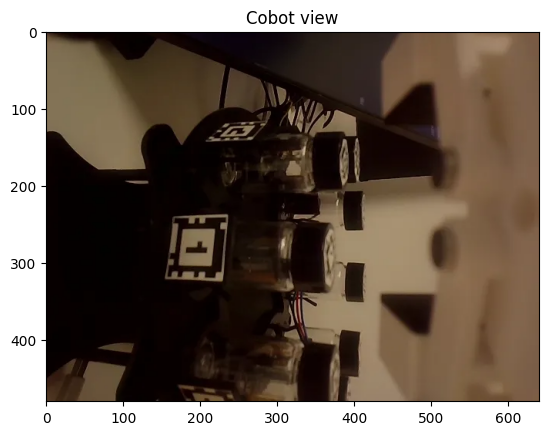

Found 2 tags

Tag ID: 3
  Center: [249.66257962 130.03764352]
  Corners: [[240.04223633 124.20635986]
 [224.68069458 137.69680786]
 [259.74551392 136.14932251]
 [272.60324097 123.00429535]]
  Translation (x, y, z): [-0.02547578 -0.03629033  0.17547742]
  Distance from camera: 18.10 centimeters
  Roll: 30.16°, Pitch: 53.94°, Yaw: 116.60°

Tag ID: 6
  Center: [196.18028172 280.28240225]
  Corners: [[177.99925232 256.81072998]
 [172.71546936 303.87536621]
 [215.27049255 304.92782593]
 [219.94659424 256.3862915 ]]
  Translation (x, y, z): [-0.03399716  0.01264745  0.13527503]
  Distance from camera: 14.01 centimeters
  Roll: 17.88°, Pitch: 12.87°, Yaw: 92.81°
Aligned pose_t (mm): [-33.99716343  12.64745283 135.27503162]
Euler angles: 0.312134134022813 0.22469352032110268 1.6198196422727311


In [210]:
result = client.predict(
	user_id=USER_ID,
	api_name="/query_camera"
)
print(result)
display_result(result)
image_path = result[1]["value"]

import numpy as np

camera_params = np.load("camera_params.npy", allow_pickle=True).item()

detections = detect_apriltags(
    image_path,
    camera_matrix=camera_params['camera_matrix'],
    dist_coeffs=camera_params['dist_coeff'],
    tag_size_meters=0.013,
    families="tagStandard52h13",
    only_ID=False
)

det = min(detections, key=lambda d: np.linalg.norm(d.pose_t))

pose_t = det.pose_t.flatten()

# Convert to mm
pose_t_mm = pose_t * 1000
x1, y1, z1 = pose_t_mm

pose_R = det.pose_R                    # shape (3, 3)
rx1, ry1, rz1 = R.from_matrix(pose_R).as_euler('xyz', degrees=False)

print("Aligned pose_t (mm):", pose_t_mm)
print("Euler angles:", rx1, ry1, rz1)

In [ ]:
# TODO: Implement turntable logic to rotate the turntable to the target position and grasp the specific vial.

Query coordinate result from the cobot, then compute object pose in the robot base frame using end-effector pose, AprilTag detection, and hand-eye calibration.

If there is an error when querying coordinates, try running the cells a few more times.

In [225]:
result = client.predict(
	user_id=USER_ID,
	api_name="/query_coords"
)
display_result(result)
coords = json.loads(result[0])["coords"]


queue status: You are next! Wait time: 36.25 seconds.
response json: None


TypeError: the JSON object must be str, bytes or bytearray, not NoneType

In [223]:
result_pose = convert(
    coords[0], coords[1], coords[2], coords[3], coords[4], coords[5], 
    x1, y1, z1, rx1, ry1, rz1,                                         
    hand_eye_calibration                                                
)

position, rx, ry, rz = result_pose
print("Target pose in robot base frame:")
print("Position:", position)
print("Rotation (Euler angles):", rx, ry, rz)
print("Robot coords:", coords)
print("AprilTag pose (mm):", pose_t_mm)
print("AprilTag euler angles:", rx1, ry1, rz1)
print("Result in base frame:", result_pose)

Target pose in robot base frame:
Position: [278.02351376 114.30844143  83.0240277 ]
Rotation (Euler angles): 2.8222664284171524 0.7404461323620225 1.8920647835805229
Robot coords: [194.2, 72.3, 201.9, 114.18, 44.39, 148.46]
AprilTag pose (mm): [-33.99716343  12.64745283 135.27503162]
AprilTag euler angles: 0.312134134022813 0.22469352032110268 1.6198196422727311
Result in base frame: (array([278.02351376, 114.30844143,  83.0240277 ]), 2.8222664284171524, 0.7404461323620225, 1.8920647835805229)


Open gripper

In [215]:
result = client.predict(
	user_id=USER_ID,
	gripper_value = 100,
	movement_speed = 100,
	api_name="/control_gripper"
)
display_result(result)

queue status: Your turn! Time remaining: 120.00 seconds.
response json: {'success': True, 'command': 'control/gripper'}


Move cobot to target position

In [220]:
print("pose_t (from AprilTag):", pose_t_mm)
print("corrected_pose_t:", corrected_pose_t)
print("position before convert():", coords[:3])
print("final converted position:", result_pose[0])
move_to_pose(result_pose)

pose_t (from AprilTag): [-33.99716343  12.64745283 135.27503162]
corrected_pose_t: [134.97907866 -14.9730718  -33.65668855]
position before convert(): [194.2, 72.3, 201.9]
final converted position: [278.02351376 114.30844143  83.0240277 ]
Sending coords (mm, deg): 278.02 114.31 83.02 161.7 42.42 108.41
queue status: Your turn! Time remaining: 73.87 seconds.
response json: {'success': True, 'command': 'control/coords'}


Close gripper

In [17]:
result = client.predict(
	user_id=USER_ID,
	gripper_value = 100,
	movement_speed = 100,
	api_name="/control_gripper"
)
display_result(result)

queue status: Your turn! Time remaining: 56.75 seconds.
response json: {'success': True, 'command': 'control/gripper'}


Lift the vial after grab

In [ ]:
move_relative(dz=50)

Move back to default place to detect apriltag

In [ ]:
result = client.predict(
    user_id=USER_ID,
    **DEFAULT_DETECTION_POSE, 
    api_name="/control_angles"
)
display_result(result)

In [ ]:
# TODO: Implement turntable logic to rotate the turntable to the target position and put the specific vial.

Detect the AprilTag at the target slot. Retry if no tag is detected.

In [ ]:
result = client.predict(
	user_id=USER_ID,
	api_name="/query_camera"
)
print(result)
display_result(result)
image_path = result[1]["value"]

import numpy as np

camera_params = np.load("camera_params.npy", allow_pickle=True).item()

detections = detect_apriltags(
    image_path,
    camera_matrix=camera_params['camera_matrix'],
    dist_coeffs=camera_params['dist_coeff'],
    tag_size_meters=0.013,
    families="tagStandard52h13",
    only_ID=False
)

det = detections[0]

pose_t = det.pose_t.flatten()
pose_R = det.pose_R

# Transform offset to camera frame
offset_in_camera = pose_R @ VIAL_OFFSET_IN_TAG

# Apply offset
corrected_pose_t = pose_t + offset_in_camera

x1, y1, z1 = corrected_pose_t
euler = R.from_matrix(pose_R).as_euler('xyz', degrees=False)
rx1, ry1, rz1 = euler

Query coordinate result from the cobot, then compute object pose in the robot base frame using end-effector pose, AprilTag detection, and hand-eye calibration.

In [ ]:
result = client.predict(
	user_id=USER_ID,
	api_name="/query_coords"
)
display_result(result)
coords = json.loads(result[0])["coords"]

result_pose = convert(
    coords[0], coords[1], coords[2], coords[3], coords[4], coords[5], 
    x1, y1, z1, rx1, ry1, rz1,                                         
    hand_eye_calibration                                                
)

position, rx, ry, rz = result_pose
print("Target pose in robot base frame:")
print("Position:", position)
print("Rotation (Euler angles):", rx, ry, rz)

Move down to place the vial

In [ ]:
move_relative(dz=-30)

Open gripper

In [19]:
result = client.predict(
	user_id=USER_ID,
	gripper_value = 100,
	movement_speed = 100,
	api_name="/control_gripper"
)
display_result(result)

queue status: Your turn! Time remaining: 41.50 seconds.
response json: {'success': True, 'command': 'control/gripper'}


Finally, move the cobot to the home palce

In [1]:
result = client.predict(
    user_id=USER_ID,
    **INITIAL_HOME_POSE, 
    api_name="/control_angles"
)
display_result(result)

NameError: name 'client' is not defined